In [1]:
import copy
import json
import pickle
import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from preprocessing import PreProcessing

In [2]:
BALL_POSSESSION_SPEED = 0.05 #Temp parameter

In [3]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    half_period="both"
)

In [4]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, half_period="both"
)

In [5]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,2,143626,5745.04,0.87421,0.49130,0.24651,0.54960,0.46768,0.45048,0.50410,...,0.06431,0.65367,0.32045,0.35375,0.44823,0.50130,0.27748,0.56585,0.03980,0.79348
143627,2,143627,5745.08,0.87414,0.49134,0.24621,0.54978,0.46737,0.45075,0.50368,...,0.06270,0.65501,0.31898,0.35450,0.44782,0.50194,0.27588,0.56625,0.03749,0.84442
143628,2,143628,5745.12,0.87409,0.49134,0.24593,0.54995,0.46703,0.45103,0.50329,...,0.06111,0.65633,0.31752,0.35531,0.44741,0.50256,0.27428,0.56658,0.03519,0.89537
143629,2,143629,5745.16,0.87405,0.49134,0.24567,0.55018,0.46668,0.45130,0.50289,...,0.05959,0.65767,0.31608,0.35611,0.44701,0.50324,0.27274,0.56694,0.03288,0.94632


In [6]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
51,1,51,2.04,0.94791,0.48986,0.64787,0.27031,0.67763,0.42630,0.68143,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
52,1,52,2.08,0.94779,0.49005,0.64797,0.27005,0.67765,0.42629,0.68101,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.49580,0.36160,0.50040,0.50384
53,1,53,2.12,0.94766,0.49025,0.64805,0.26978,0.67767,0.42637,0.68060,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.49770,0.50397
54,1,54,2.16,0.94756,0.49039,0.64815,0.26943,0.67769,0.42634,0.68020,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.49500,0.50410
55,1,55,2.20,0.94746,0.49049,0.64826,0.26908,0.67770,0.42630,0.67978,...,0.43317,0.37719,0.49505,0.02218,0.50195,0.50356,0.49605,0.36121,0.49230,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,2,140294,5611.76,0.07220,0.42214,0.26780,0.11043,0.21891,0.46781,0.20782,...,0.49772,0.52487,0.27637,0.26292,0.25979,0.62951,0.34514,0.14116,0.40008,-0.01407
140295,2,140295,5611.80,0.07237,0.42203,0.26741,0.10964,0.21913,0.46735,0.20811,...,0.49752,0.52392,0.27627,0.26169,0.25982,0.62926,0.34550,0.14096,0.40246,-0.02028
140296,2,140296,5611.84,0.07254,0.42190,0.26701,0.10887,0.21936,0.46697,0.20841,...,0.49732,0.52299,0.27618,0.26049,0.25988,0.62906,0.34586,0.14079,0.40483,-0.02649
140297,2,140297,5611.88,0.07271,0.42170,0.26664,0.10813,0.21957,0.46649,0.20873,...,0.49711,0.52208,0.27610,0.25931,0.25995,0.62887,0.34623,0.14065,0.40721,-0.03270


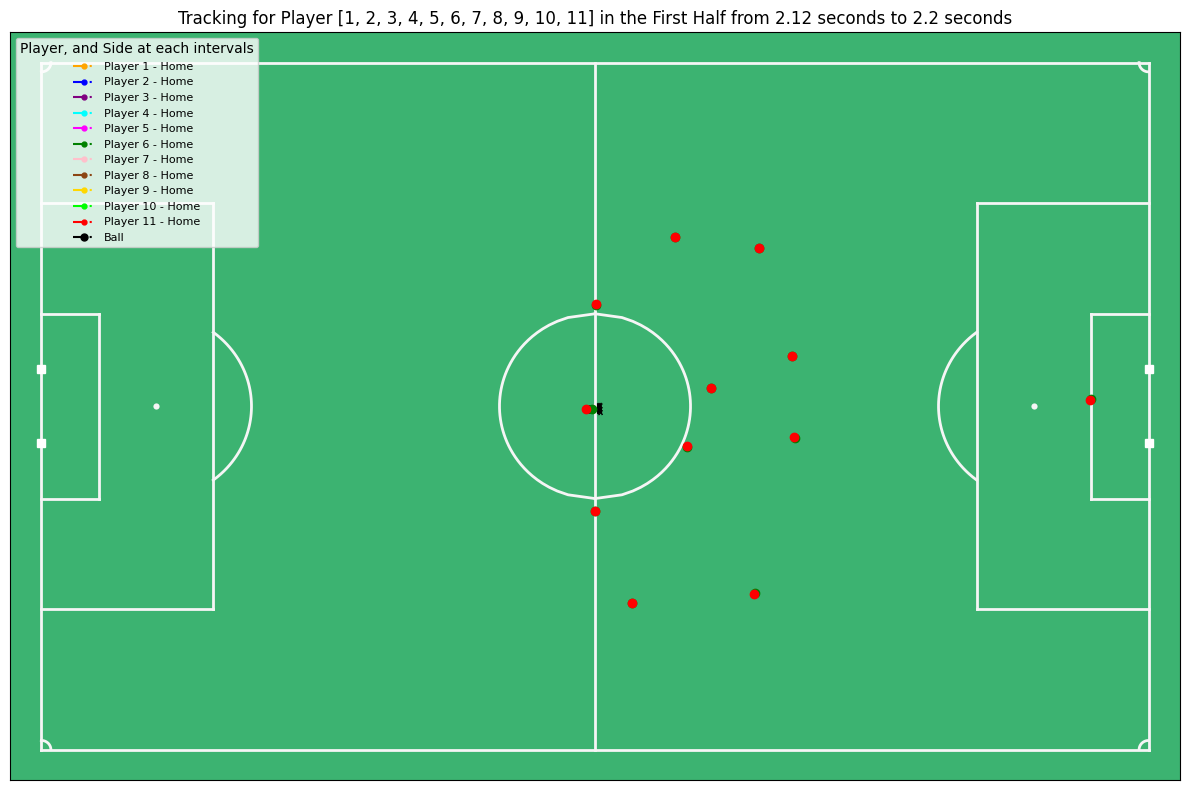

In [7]:
game_2_pre.player_tracking(game_2_data.iloc[2:5], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=True)

# Tracking players closest to the ball using frames

In [8]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.123138,-0.701914
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,3.800185e-01,0.029611,0.740275,0.415521,-17.690434
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,1.725677e-01,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,2,143626,5745.04,0.87421,0.49130,0.24651,0.54960,0.46768,0.45048,0.50410,...,0.053610,-0.037042,0.042045,0.013916,0.019002,-4.280448e-02,0.042220,-0.013368,1.275058,0.000282
143627,2,143627,5745.08,0.87414,0.49134,0.24621,0.54978,0.46737,0.45075,0.50368,...,0.052367,-0.031080,0.041257,-0.019714,0.019002,7.719519e-14,0.041231,-0.024734,1.274809,-0.006244
143628,2,143628,5745.12,0.87409,0.49134,0.24593,0.54995,0.46703,0.45103,0.50329,...,0.051663,-0.017603,0.041741,0.012105,0.018583,-1.047647e-02,0.040842,-0.009728,1.275047,0.005961
143629,2,143629,5745.16,0.87405,0.49134,0.24567,0.55018,0.46668,0.45130,0.50289,...,0.050658,-0.025120,0.041183,-0.013962,0.019723,2.851242e-02,0.039538,-0.032599,1.275058,0.000282


In [10]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[:, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[:, "P_11_velocity":]

assert game_1_players.shape[0] == game_1_ball.shape[0] == game_1_vel_acc.shape[0]
assert game_2_players.shape[0] == game_2_ball.shape[0] == game_2_vel_acc.shape[0]

In [11]:
game_1_vel_acc

,P_11_velocity,P_11_acceleration,P_1_velocity,P_1_acceleration,P_2_velocity,P_2_acceleration,P_3_velocity,P_3_acceleration,P_4_velocity,P_4_acceleration,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003500,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,0.004500,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.123138,-0.701914
4,0.001750,-0.068750,0.006619,0.165478,0.031445,0.786135,0.007558,0.188953,0.005397,0.134919,...,0.011138,0.278458,0.019121,0.478033,0.015201,3.800185e-01,0.029611,0.740275,0.415521,-17.690434
5,0.002000,0.006250,0.013530,0.172774,0.009451,-0.549872,0.006576,-0.024541,0.020555,0.378951,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,1.725677e-01,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,0.003717,-0.044729,0.009223,-0.008647,0.010262,0.030084,0.011413,-0.011014,0.024932,-0.034129,...,0.053610,-0.037042,0.042045,0.013916,0.019002,-4.280448e-02,0.042220,-0.013368,1.275058,0.000282
143627,0.002016,-0.042524,0.008746,-0.011913,0.010277,0.000380,0.011853,0.011014,0.023368,-0.039111,...,0.052367,-0.031080,0.041257,-0.019714,0.019002,7.719519e-14,0.041231,-0.024734,1.274809,-0.006244
143628,0.001250,-0.019139,0.008189,-0.013931,0.011011,0.018349,0.011448,-0.010125,0.023485,0.002935,...,0.051663,-0.017603,0.041741,0.012105,0.018583,-1.047647e-02,0.040842,-0.009728,1.275047,0.005961
143629,0.001000,-0.006250,0.008678,0.012228,0.011051,0.000992,0.010680,-0.019206,0.023308,-0.004441,...,0.050658,-0.025120,0.041183,-0.013962,0.019723,2.851242e-02,0.039538,-0.032599,1.275058,0.000282


In [12]:
game_1_result = pd.DataFrame(index=game_1_data.index)
game_1_result["Time [s]"] = game_1_data["Time [s]"]

for i in range(0, game_1_players.shape[1] - 1, 2):
    ply_x, ply_y = game_1_players.iloc[:, i], game_1_players.iloc[:, i + 1]
    eu_x = np.square(ply_x - game_1_ball["Ball-x"])
    eu_y = np.square(ply_y - game_1_ball["Ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    game_1_result[f"{game_1_players.columns[i][:-2]}"] = distance

In [13]:
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.463795,0.295416,0.155454,0.148886,0.219595,0.341617,0.098830,0.088441,0.175352,...,0.220884,0.235846,0.436262,0.232928,0.000000,0.309003,0.107827,0.558025,0.337539,0.136614
2,0.08,0.501257,0.299551,0.179323,0.194075,0.261277,0.330581,0.107148,0.132807,0.199417,...,0.217031,0.190031,0.399390,0.226727,0.046049,0.278446,0.061778,0.536677,0.361474,0.177678
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,5745.04,0.887442,0.319697,0.548389,0.512825,0.142406,0.270804,0.065214,0.663300,0.255111,...,0.077999,0.163450,0.154023,0.480962,0.323491,0.350876,0.141942,0.521658,0.502179,0.329101
143627,5745.08,0.908102,0.361077,0.582900,0.538187,0.190894,0.321644,0.087380,0.703998,0.304952,...,0.127447,0.213355,0.197891,0.517204,0.373471,0.400750,0.191080,0.565029,0.534475,0.366345
143628,5745.12,0.931125,0.404631,0.619616,0.567082,0.240792,0.372413,0.128553,0.745867,0.355096,...,0.178403,0.263251,0.244708,0.555618,0.423634,0.451029,0.240441,0.609405,0.569408,0.406530
143629,5745.16,0.956334,0.449674,0.658200,0.598915,0.291388,0.423557,0.175894,0.788798,0.405482,...,0.229871,0.313159,0.293137,0.595734,0.473860,0.501862,0.289883,0.654637,0.606485,0.448845


In [14]:
idx = game_1_result.min(axis=1).round(4)
game_1_closest_to_ball = game_1_result.idxmin(axis=1)
# print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, game_1_closest_to_ball, idx)))

In [15]:
game_2_result = pd.DataFrame(index=game_2_data.index)
game_2_result["Time [s]"] = game_1_data["Time [s]"]

for i in range(0, game_2_players.shape[1] - 1, 2):
    ply_x, ply_y = game_2_players.iloc[:, i], game_2_players.iloc[:, i + 1]
    eu_x = np.square(ply_x - game_2_ball["Ball-x"])
    eu_y = np.square(ply_y - game_2_ball["Ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    game_2_result[f"{game_2_players.columns[i][:-2]}"] = distance

In [16]:
idx = game_2_result.min(axis=1).round(4)
game_2_closest_to_ball = game_2_result.idxmin(axis=1)
# print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, game_2_closest_to_ball, idx)))

In [26]:
game_1_min_dist_to_ball = pd.DataFrame(index=game_1_data.index)
game_1_min_dist_to_ball["Time [s]"] = game_1_data["Time [s]"]

x_columns = np.array([f"{player}-x" for player in game_1_closest_to_ball.values])
y_columns = np.array([f"{player}-y" for player in game_1_closest_to_ball.values])

for row, x, y in zip(game_1_min_dist_to_ball.index, x_columns, y_columns):  
    temp_x = game_1_data.loc[row, x]
    temp_y = game_1_data.loc[row, y]
    
    game_1_min_dist_to_ball.loc[row, "Home-Player0-x"] = temp_x
    game_1_min_dist_to_ball.loc[row, "Home-Player0-y"] = temp_y
        
    game_1_min_dist_to_ball.loc[row, x] = temp_x
    game_1_min_dist_to_ball.loc[row, y] = temp_y
    
game_1_min_dist_to_ball[["Ball-x", "Ball-y"]] = game_1_data[["Ball-x", "Ball-y"]]

KeyboardInterrupt: 

In [18]:
game_1_min_dist_to_ball

,Time [s],Home-Player0-x,Home-Player0-y,Away-Player19-x,Away-Player19-y,Home-Player9-x,Home-Player9-y,Home-Player10-x,Home-Player10-y,Away-Player15-x,...,Home-Player7-x,Home-Player7-y,Away-Player23-x,Away-Player23-y,Home-Player4-x,Home-Player4-y,Home-Player11-x,Home-Player11-y,Ball-x,Ball-y
1,0.04,0.45472,0.38709,0.45472,0.38709,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
2,0.08,0.52697,0.37980,NaN,NaN,0.52697,0.3798,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
3,0.12,0.55243,0.43269,NaN,NaN,NaN,NaN,0.55243,0.43269,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
4,0.16,0.55236,0.43313,NaN,NaN,NaN,NaN,0.55236,0.43313,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
5,0.20,0.55202,0.43311,NaN,NaN,NaN,NaN,0.55202,0.43311,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,5745.04,0.10496,0.79082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03980,0.79348
143627,5745.08,0.10530,0.78931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03749,0.84442
143628,5745.12,0.10561,0.78782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03519,0.89537
143629,5745.16,0.10588,0.78629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03288,0.94632


In [20]:
game_2_min_dist_to_ball = pd.DataFrame(index=game_2_data.index)
game_2_min_dist_to_ball["Time [s]"] = game_2_data["Time [s]"]

x_columns = np.array([f"{player}-x" for player in game_2_closest_to_ball.values])
y_columns = np.array([f"{player}-y" for player in game_2_closest_to_ball.values])

for row, x, y in zip(game_2_min_dist_to_ball.index, x_columns, y_columns):       
    temp_x = game_2_data.loc[row, x]
    temp_y = game_2_data.loc[row, y]
    
    game_2_min_dist_to_ball.loc[row, "Home-Player0-x"] = temp_x
    game_2_min_dist_to_ball.loc[row, "Home-Player0-y"] = temp_y
        
    game_2_min_dist_to_ball.loc[row, x] = temp_x
    game_2_min_dist_to_ball.loc[row, y] = temp_y
    
game_2_min_dist_to_ball[["Ball-x", "Ball-y"]] = game_2_data[["Ball-x", "Ball-y"]]

In [21]:
game_2_min_dist_to_ball

,Time [s],Home-Player0-x,Home-Player0-y,Away-Player23-x,Away-Player23-y,Away-Player20-x,Away-Player20-y,Home-Player9-x,Home-Player9-y,Away-Player21-x,...,Away-Player22-x,Away-Player22-y,Home-Player11-x,Home-Player11-y,Home-Player2-x,Home-Player2-y,Away-Player25-x,Away-Player25-y,Ball-x,Ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
52,2.08,0.50214,0.50371,0.50214,0.50371,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50040,0.50384
53,2.12,0.50209,0.50366,0.50209,0.50366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49770,0.50397
54,2.16,0.50203,0.50361,0.50203,0.50361,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49500,0.50410
55,2.20,0.50195,0.50356,0.50195,0.50356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49230,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,5611.76,0.37456,0.09483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40008,-0.01407
140295,5611.80,0.37558,0.09270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40246,-0.02028
140296,5611.84,0.37663,0.09069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40483,-0.02649
140297,5611.88,0.37770,0.08862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40721,-0.03270


In [22]:
delete_idx = game_1_vel_acc[game_1_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_1_min_dist_to_ball = game_1_min_dist_to_ball.loc[~game_1_min_dist_to_ball.index.isin(delete_idx), :]

In [23]:
delete_idx = game_2_vel_acc[game_2_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_2_min_dist_to_ball = game_2_min_dist_to_ball.loc[~game_2_min_dist_to_ball.index.isin(delete_idx), :]

In [24]:
game_2_min_dist_to_ball

,Time [s],Home-Player0-x,Home-Player0-y,Away-Player23-x,Away-Player23-y,Away-Player20-x,Away-Player20-y,Home-Player9-x,Home-Player9-y,Away-Player21-x,...,Away-Player22-x,Away-Player22-y,Home-Player11-x,Home-Player11-y,Home-Player2-x,Home-Player2-y,Away-Player25-x,Away-Player25-y,Ball-x,Ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
52,2.08,0.50214,0.50371,0.50214,0.50371,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50040,0.50384
88,3.52,0.40435,0.50838,NaN,NaN,0.40435,0.50838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40419,0.50835
89,3.56,0.40453,0.50842,NaN,NaN,0.40453,0.50842,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40435,0.50838
90,3.60,0.40471,0.50846,NaN,NaN,0.40471,0.50846,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40453,0.50842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140119,5604.76,0.53720,0.77274,NaN,NaN,NaN,NaN,NaN,NaN,0.53720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53797,0.77410
140120,5604.80,0.53643,0.77139,NaN,NaN,NaN,NaN,NaN,NaN,0.53643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53718,0.77271
140121,5604.84,0.53570,0.77003,NaN,NaN,NaN,NaN,NaN,NaN,0.53570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53641,0.77135
140122,5604.88,0.53501,0.76876,NaN,NaN,NaN,NaN,NaN,NaN,0.53501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53568,0.77000


In [25]:
temp = list(game_2_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 12
    if len(temp[i]) == 15:
        end = 13
    player_col.append(temp[i][11:end])
    sides.append(temp[i][:4])

In [61]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [62]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_game_2_min_dist_to_ball = game_2_min_dist_to_ball.iloc[idxs, :]

In [72]:
dif_game_2_min_dist_to_ball

,Time [s],Home-Player0-x,Home-Player0-y,Away-Player23-x,Away-Player23-y,Away-Player20-x,Away-Player20-y,Home-Player9-x,Home-Player9-y,Away-Player21-x,...,Away-Player22-x,Away-Player22-y,Home-Player11-x,Home-Player11-y,Home-Player2-x,Home-Player2-y,Away-Player25-x,Away-Player25-y,Ball-x,Ball-y
51,2.04,0.50216,0.50376,0.50216,0.50376,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
88,3.52,0.40435,0.50838,NaN,NaN,0.40435,0.50838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40419,0.50835
187,7.48,0.44388,0.22400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44312,0.22434
284,11.36,0.31168,0.27972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31207,0.27952
348,13.92,0.26170,0.57862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26207,0.57818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138250,5530.00,0.33045,0.05978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33045,0.05978
139891,5595.64,0.70202,0.51949,NaN,NaN,NaN,NaN,0.70202,0.51949,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.70202,0.51949
139927,5597.08,0.98530,0.52150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.9853,0.5215,0.98556,0.52120
140077,5603.08,0.59766,0.81334,NaN,NaN,NaN,NaN,NaN,NaN,0.59766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59957,0.81301


In [100]:
smaller_dataset = dif_game_2_min_dist_to_ball.loc[55000:65000]

In [101]:
assert len(dif_game_2_min_dist_to_ball) == len(dif_player_col)

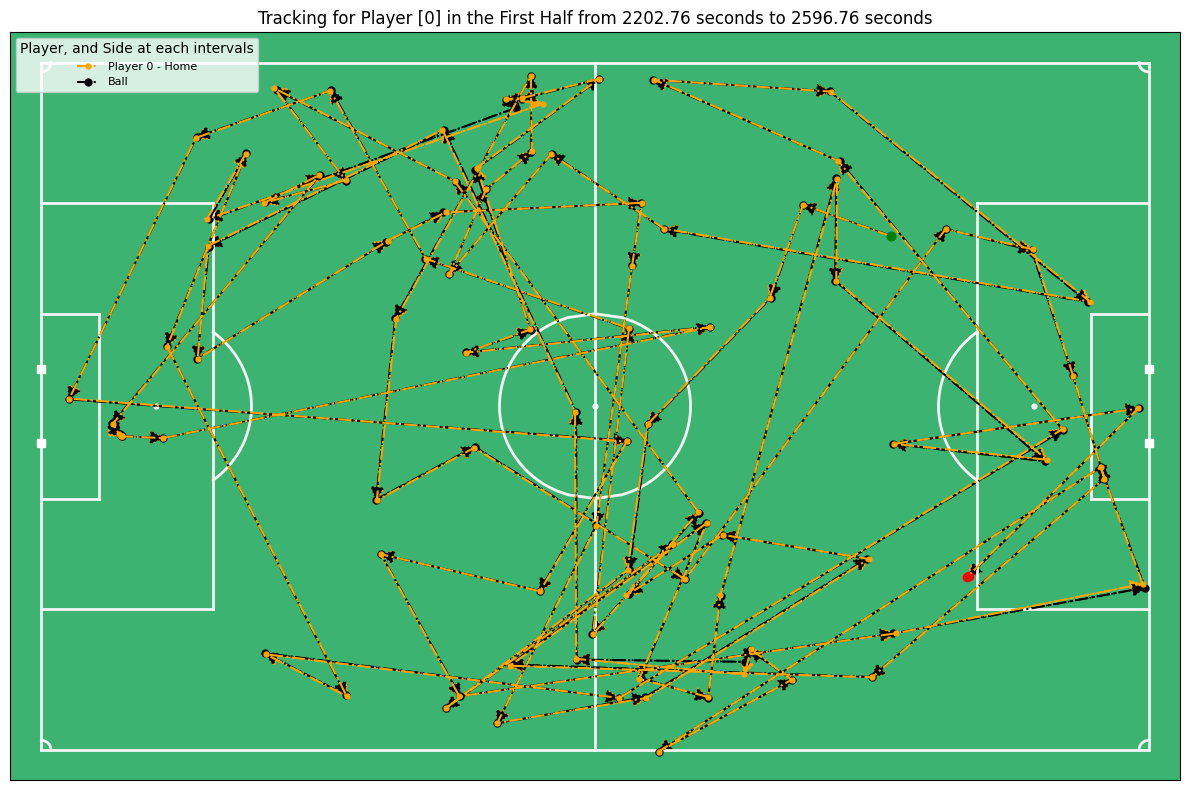

In [102]:
game_1_pre.player_tracking(smaller_dataset, plot_ball=True, players=[0], use_annotation=None, sides=["Home"]) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [26]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [27]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [28]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [29]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,RECOVERY,143617,143617,Player16,NaN


In [30]:
game_2_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,51,51,Player23,NaN
1,PASS,51,87,Player23,Player20
2,PASS,146,186,Player20,Player18
3,PASS,248,283,Player18,Player17
4,PASS,316,346,Player17,Player16
...,...,...,...,...,...
1930,BALL LOST,140122,140183,Player21,NaN
1931,CHALLENGE,140180,140180,Player1,NaN
1932,CHALLENGE,140183,140183,Player24,NaN
1933,RECOVERY,140211,140211,Player12,NaN


In [31]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [32]:
game_1_event_data = fix_events(game_1_event_data)
game_2_event_data = fix_events(game_2_event_data)

In [33]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_min_dist_to_ball.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(i, j + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

In [34]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143615,BALL LOST
143616,BALL LOST
143617,RECOVERY
143618,BALL LOST


In [35]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_min_dist_to_ball.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(i, j + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))

game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

In [36]:
game_2_event

,Type
52,PASS
53,PASS
54,PASS
55,PASS
56,PASS
...,...
140180,CHALLENGE
140181,BALL LOST
140182,BALL LOST
140183,CHALLENGE


In [37]:
game_2_event = game_2_event[~(game_2_event["Type"] == "CARD")]

In [46]:
temp_1 = game_1_min_dist_to_ball.loc[:, "Away-Player19-x":].fillna(0.0)
temp_2 = game_2_min_dist_to_ball.loc[:, "Away-Player23-x":].fillna(0.0)

In [57]:
temp_1

,Away-Player19-x,Away-Player19-y,Home-Player9-x,Home-Player9-y,Home-Player10-x,Home-Player10-y,Away-Player15-x,Away-Player15-y,Away-Player21-x,Away-Player21-y,...,Home-Player7-x,Home-Player7-y,Away-Player23-x,Away-Player23-y,Home-Player4-x,Home-Player4-y,Home-Player11-x,Home-Player11-y,Ball-x,Ball-y
1,0.45472,0.38709,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45472,0.38709
18,0.00000,0.00000,0.0,0.0,0.0,0.0,0.57428,0.20464,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57502,0.20554
19,0.00000,0.00000,0.0,0.0,0.0,0.0,0.57343,0.20364,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57426,0.20462
20,0.00000,0.00000,0.0,0.0,0.0,0.0,0.57249,0.20276,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57341,0.20362
21,0.00000,0.00000,0.0,0.0,0.0,0.0,0.57151,0.20183,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57247,0.20274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143542,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10063,0.96636
143543,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10005,0.96451
143620,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05090,0.62124
143621,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04972,0.62269


In [78]:
common_index = temp_1.index.intersection(game_1_event.index)
X_1 = temp_1.loc[common_index].values
y_1 = game_1_event.loc[common_index]

common_index = temp_2.index.intersection(game_2_event.index)
X_2 = temp_2.loc[common_index].values
y_2 = game_2_event.loc[common_index]

In [79]:
assert X_1.shape[0] == y_1.shape[0]
assert X_2.shape[0] == y_2.shape[0]

In [80]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([ 966,   33,   73,    5, 1194,   27,   63,    9], dtype=int64))

In [81]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([ 610,  130,  109,    7, 1314,   32,   68,   23], dtype=int64))

In [82]:
scaler = MinMaxScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)

In [83]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_2 = label_encoder.transform(y_2)

C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\noill\OneDrive\Desktop\module\Masters Thesis\Thesis\Real-Time LLM Football Commentary\.venv\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [84]:
print(X_1.shape)
print(X_2.shape)

(2370, 46)
(2293, 46)


In [85]:
X_1 = X_1[:2370]
y_1 = y_1[:2370]

X_2 = X_2[:2290]
y_2 = y_2[:2290]

In [86]:
print(X_1.shape)
print(X_2.shape)

(2370, 46)
(2290, 46)


In [87]:
# common_features = list(set(X_1.columns) & set(X_2.columns))
# X_1_common = X_1[common_features]
# X_2_common = X_2[common_features]

In [88]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
clf.fit(X_1, y_1)
y_pred = clf.predict(X_2)
accuracy_score(y_2, y_pred)

0.5170305676855895

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [90]:
np.unique(y_1).shape, np.unique(y_2).shape

((8,), (8,))

In [93]:
assert X_1.shape[1] == X_2.shape[1]
assert np.unique(y_1).shape[0] == np.unique(y_2).shape[0]

input_size = X_1.shape[1]
hidden_size = 256
num_layers = 3
num_classes = np.unique(y_1).shape[0]
sequence_length = 10
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [94]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Convert pandas DataFrame/numpy arrays to PyTorch tensors
        self.features = torch.tensor(features.values if hasattr(features, 'values') else features, 
                                     dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, 'values') else labels, 
                                   dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Reshape the NumPy array
X_1_reshaped = X_1.reshape(-1, sequence_length, input_size)
X_2_reshaped = X_2.reshape(-1, sequence_length, input_size)
# X_new_reshaped = X_new.values.reshape(-1, sequence_length, input_size)

# Create DataLoaders
training_dataset = CustomDataset(X_1_reshaped, y_1)
validation_dataset = CustomDataset(X_2_reshaped, y_2)
# testing_dataset = CustomDataset(X_new_reshaped, y_new)

train_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

# test_loader = DataLoader(
#     dataset=testing_dataset, 
#     batch_size=batch_size, 
#     shuffle=False,
# )

In [95]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
        self.init_weights()

    def init_weights(self):
        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
       
        nn.init.xavier_uniform_(self.fc.weight)

        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
                    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [96]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model

LSTM(
  (lstm): LSTM(46, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=2560, out_features=8, bias=True)
)

In [98]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=9)

accu = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

for epoch in range(num_epochs):
    train_acc = 0
    val_acc = 0
    total_train_loss = 0
    total_val_loss = 0
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)
        train_loss = criterion(outputs, label)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).sum().item()

    train_acc /= len(train_loader.dataset)
    avg_train_loss = total_train_loss / len(train_loader)
    accu["training_accuracy"].append(train_acc)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            val_loss = criterion(outputs, label)

            total_val_loss += val_loss.item()
            _, pred = torch.max(outputs.data, 1)
            val_acc += (pred == label).sum().item()

    val_acc /= len(validation_loader.dataset)
    avg_val_loss = total_val_loss / len(validation_loader)
    accu["validation_accuracy"].append(val_acc)
        
    scheduler.step(avg_val_loss)
    
    print(f"Epoch[{epoch + 1}] | "
          f"training accuracy: {train_acc * 100:0.2f}% | "
          f"validation accuracy: {val_acc * 100:0.2f}% | "
          f"train loss: {avg_train_loss:.4f} | "
          f"val loss: {avg_val_loss:.4f} | "
          f"learning rate: {optimizer.param_groups[0]['lr']:.4f}")

Epoch[1] | training accuracy: 74.26% | validation accuracy: 40.61% | train loss: 0.7111 | val loss: 1.5555 | learning rate: 0.0010
Epoch[2] | training accuracy: 71.31% | validation accuracy: 40.61% | train loss: 0.7118 | val loss: 1.5550 | learning rate: 0.0010
Epoch[3] | training accuracy: 71.73% | validation accuracy: 41.05% | train loss: 0.7084 | val loss: 1.5544 | learning rate: 0.0010
Epoch[4] | training accuracy: 72.15% | validation accuracy: 41.05% | train loss: 0.7108 | val loss: 1.5536 | learning rate: 0.0010
Epoch[5] | training accuracy: 73.84% | validation accuracy: 41.05% | train loss: 0.7096 | val loss: 1.5527 | learning rate: 0.0010
Epoch[6] | training accuracy: 72.15% | validation accuracy: 41.05% | train loss: 0.7118 | val loss: 1.5518 | learning rate: 0.0010
Epoch[7] | training accuracy: 71.31% | validation accuracy: 40.61% | train loss: 0.7110 | val loss: 1.5509 | learning rate: 0.0010
Epoch[8] | training accuracy: 72.15% | validation accuracy: 40.61% | train loss: 0.

In [221]:
test_acc = 0

model.eval()

with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        
        outputs = model(data)
        
        _, pred = torch.max(outputs.data, 1)
        test_acc += (pred == label).sum().item()

    test_acc /= len(testing_loader.dataset)
    # acc["testing_accuracy"].append(val_acc)

print(f"Accuracy on test set: {test_acc * 100:.2f}%")

NameError: name 'test_loader' is not defined

In [214]:
def plot_accuracy(accuracy):    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title("Learning curve")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

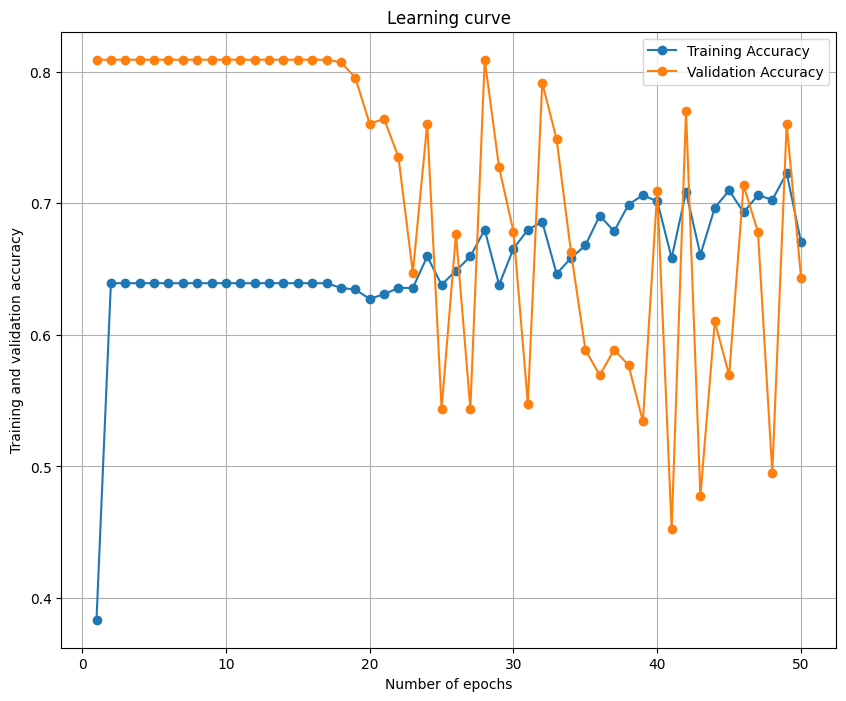

In [215]:
plot_accuracy(acc)